# Creating a toy multi-class dataset

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


In [2]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [3]:
x_blob,y_blob=make_blobs(n_samples=1000,
                         n_features=NUM_FEATURES,
                         centers=NUM_CLASSES,
                         cluster_std=1.5,#决定混乱程度
                         random_state=RANDOM_SEED)

In [4]:
x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [5]:
x_blob_train,x_blob_test,y_blob_train,y_blob_test=train_test_split(x_blob,
                                                                   y_blob,
                                                                   test_size=0.2,
                                                                   random_state=RANDOM_SEED)

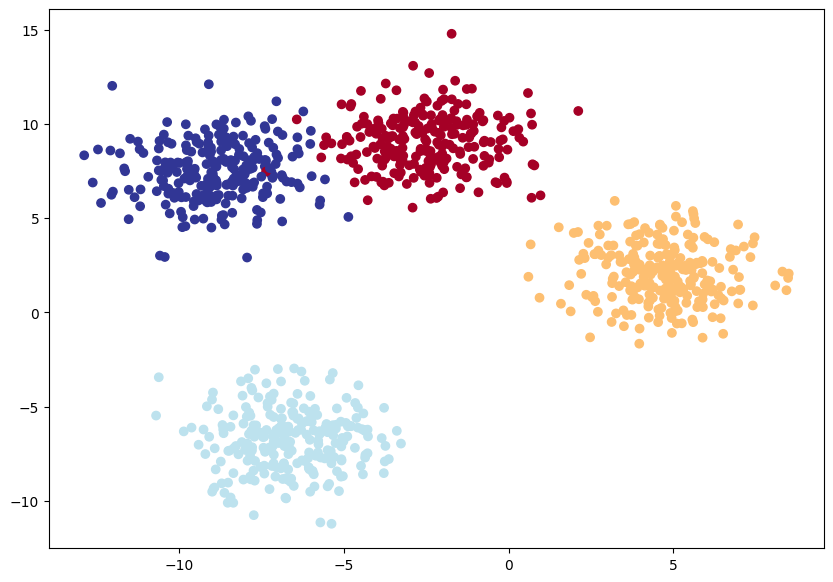

In [6]:
plt.figure(figsize=(10,7))
plt.scatter(x_blob[:,0],x_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)
plt.show()

# build a model

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
import torch.nn as nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hideen_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hideen_units),
            nn.ReLU(),
            nn.Linear(in_features=hideen_units,out_features=hideen_units),
            nn.ReLU(),
            nn.Linear(in_features=hideen_units,out_features=output_features)
        )

    def forward(self,x):
        return self.linear_layer_stack(x)


In [9]:
x_train, y_train, x_test, y_test = x_blob_train.to(device), y_blob_train.to(device), x_blob_test.to(device), y_blob_test.to(device)

In [10]:
x_train.shape,y_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0], device='cuda:0'))

In [11]:
model_0=BlobModel(input_features=2,
                  output_features=4,
                  hideen_units=8).to(device)
model_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [12]:
def accuracy_fn(y_pred,y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    return correct/len(y_pred)*100

In [13]:
epoches=1000

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.05)



In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [15]:
print(y_test.dtype, y_test.shape)

torch.int64 torch.Size([200])


In [16]:
for epoch in range(epoches):
    model_0.train()
    y_logits=model_0(x_train)
    y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_train,y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    model_0.eval()
    with torch.inference_mode():
        test_logits=model_0(x_test)
        test_preds=torch.softmax(test_logits,dim=1).argmax(dim=1)
        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_fn(y_test,test_preds)
    
    if epoch%100==0:
        print(f"Epoch:{epoch} | Loss:{loss} | Test loss:{test_loss} | ACC:{acc}")     

Epoch:0 | Loss:1.671864628791809 | Test loss:1.3257362842559814 | ACC:0.0
Epoch:100 | Loss:0.05190858989953995 | Test loss:0.04118286445736885 | ACC:99.25
Epoch:200 | Loss:0.03455865755677223 | Test loss:0.02442925050854683 | ACC:99.125
Epoch:300 | Loss:0.02997702918946743 | Test loss:0.01972186379134655 | ACC:99.125
Epoch:400 | Loss:0.027709852904081345 | Test loss:0.01742371916770935 | ACC:99.125
Epoch:500 | Loss:0.026563439518213272 | Test loss:0.01612124964594841 | ACC:99.125
Epoch:600 | Loss:0.02581799030303955 | Test loss:0.015256386250257492 | ACC:99.125
Epoch:700 | Loss:0.0252788495272398 | Test loss:0.014620261266827583 | ACC:99.125
Epoch:800 | Loss:0.024851243942975998 | Test loss:0.014139818027615547 | ACC:99.25
Epoch:900 | Loss:0.024496758356690407 | Test loss:0.013751399703323841 | ACC:99.25


In [19]:
model_0.eval()
with torch.inference_mode():
    y_logits_test = model_0(x_test)
y_logits_test[:10]


tensor([[  4.1934,  14.2703,  -4.9240, -11.7453],
        [  3.3747, -13.0963,  -2.7723,   9.8965],
        [ -5.4626,  -0.9898,   8.2546,  -3.0546],
        [  1.7910,   8.9078,  -2.2044,  -6.7399],
        [ 10.5728,   2.5725, -11.4477,  -7.1325],
        [  3.9456, -15.6429,  -3.1994,  11.6976],
        [ -5.0300,  -0.7647,   7.5211,  -2.7123],
        [  8.6222,  -1.7801,  -9.1590,  -2.3062],
        [ -6.2940,  -1.8340,   9.7106,  -3.3845],
        [  9.3161,  -0.2284,  -9.9942,  -4.1708]], device='cuda:0')

In [21]:
y_pred_test = torch.softmax(y_logits_test, dim = 1)
y_pred_test[:10]

tensor([[4.2038e-05, 9.9996e-01, 4.6132e-09, 5.0300e-12],
        [1.4689e-03, 1.0321e-10, 3.1431e-06, 9.9853e-01],
        [1.1031e-06, 9.6638e-05, 9.9989e-01, 1.2258e-05],
        [8.1071e-04, 9.9917e-01, 1.4917e-05, 1.5993e-07],
        [9.9966e-01, 3.3528e-04, 2.7321e-10, 2.0444e-08],
        [4.2970e-04, 1.3365e-12, 3.3895e-07, 9.9957e-01],
        [3.5398e-06, 2.5200e-04, 9.9971e-01, 3.5938e-05],
        [9.9995e-01, 3.0360e-05, 1.8954e-08, 1.7940e-05],
        [1.1202e-07, 9.6889e-06, 9.9999e-01, 2.0553e-06],
        [9.9993e-01, 7.1586e-05, 4.1077e-09, 1.3890e-06]], device='cuda:0')

In [26]:
y_preds_test = torch.argmax(y_pred_test, dim=1)
y_preds_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [27]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [29]:
y_blob_test == y_preds_test.cpu()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

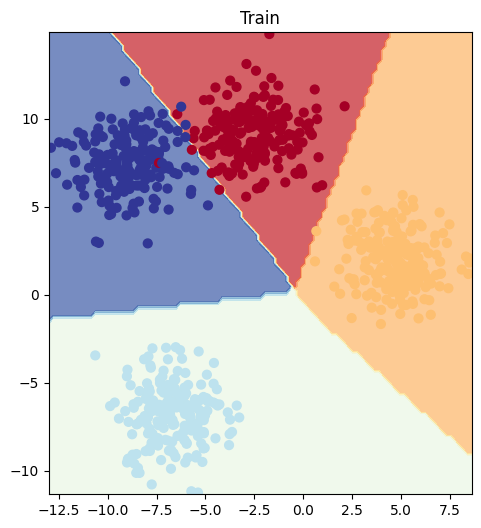

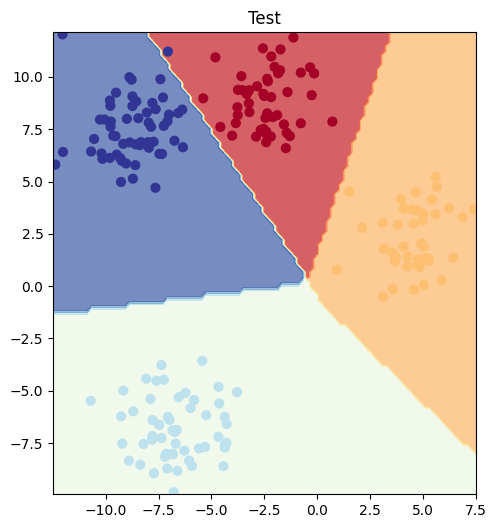

In [31]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, x_blob_train, y_blob_train)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, x_blob_test, y_blob_test)